In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from scipy import signal


In [2]:
ion_props = pd.DataFrame({'Ion': ['Na', 'K', 'Cl', 'Ca'],
                          'Out_mM': [140, 3, 140, 1.5],
                          'In_mM': [7, 140, 7, 0.0001],
                          'Charge': [1, 1, -1, 2]})
ion_props.set_index('Ion', inplace=True)

In [3]:
# Calculate reversal potential using Nernst equation
def nernst(conc_o, conc_i, z, t=310):
    # default temperature, t, is body temperature in Kelvin
    R = 8.314 # ideal gas constant
    F = 96485 # Faraday's constant
    e_r = R*t/(z*F)*np.log(conc_o/conc_i)
    return e_r

In [4]:
ion_props['Er_mV'] = nernst(ion_props['Out_mM'], ion_props['In_mM'], ion_props['Charge'])*1000

In [5]:
ion_props

,Out_mM,In_mM,Charge,Er_mV
Ion,,,,
Na,140.0,7.0000,1,80.023015
K,3.0,140.0000,1,-102.656323
Cl,140.0,7.0000,-1,-80.023015
Ca,1.5,0.0001,2,128.430326


In [6]:
# parameters
i_spk = 3 # action potential current in nA
i_syn = 0.02 * 20000 * 0.002 # synaptic current nA, current of single synapse X number_syn X prob_presyn_active

c_ext = 0.3 # conductivity in S/m

dt = 0.001 # time step in s
dx = 0.0001 # space step in m
area_sim = 0.05 # length of simulated surface, in m
dur_sim = 1 # duration of simulation, in s

scale_loc = 4 # scaling term for global signal


In [7]:
t = np.arange(0, dur_sim, dt) # time vector
locs = np.arange(-area_sim/2, area_sim/2, dx) # location vector

# inputs
sig_gbl = signal.detrend(np.cumsum(np.random.normal(0, 1, t.size)))/10 # global input
sig_gbl = np.convolve(sig_gbl, np.ones(10)/10, mode='same') # smooth global input

# convolve sig_loc with a gaussian kernel
sig_kern = np.exp(-np.linspace(-3, 3, 200)**2);
sig_loc = np.zeros(t.size) # local input
sig_loc[np.where((t >=0.2)&(t<0.3), True, False)] = 1 
sig_loc = np.convolve(sig_loc, sig_kern/np.sum(sig_kern), mode='same')

# noise input
sig_noise = np.random.normal(0, 0.1, (locs.size, t.size))

# total signal
inp_gbl = sig_gbl * np.ones((locs.size,1))
inp_loc = sig_loc * np.exp(-locs**2/(2*0.01**2)).reshape((locs.size,1))
inp = (inp_gbl + (inp_loc + sig_noise) * scale_loc)

# simulate spiking
spks = np.random.poisson(np.exp(inp)*dt, (locs.size, t.size)) # simulate spiking

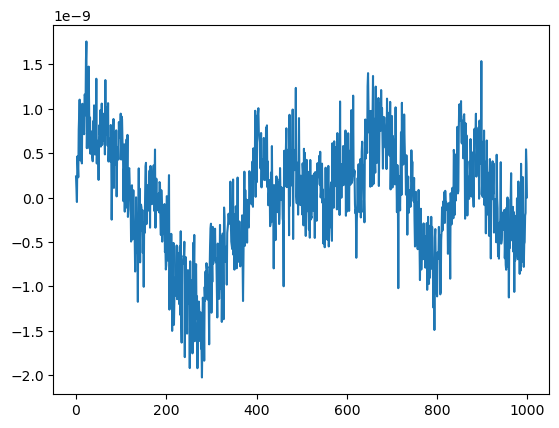

In [8]:
i_sim = -(inp*i_syn + spks*i_spk) * 10**-9# simulate current
fig, ax = plt.subplots()
ax.plot(i_sim[0,:])
plt.show()